# **TREES** 🌳

this script is for setup, execution, and analysis of the different algorithms that use decision trees

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import funcs as f
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from tabulate import tabulate

In [2]:
'''
Import data from data_organization.ipynb and set random seed

'''

df_a = pd.read_csv('../data/df_all.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_b = pd.read_csv('../data/df_gus.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_c = pd.read_csv('../data/df_tgus.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_d = pd.read_csv('../data/df_us.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
#df_raw = pd.read_csv('../data/df_raw.csv').drop(['Unnamed: 0', 'offset'], axis = 1)

a_name = 'Add Sand, Silt, Clay'
b_name = 'Add Sand, Silt'
c_name = 'Add Sand'
d_name = 'US'
np.random.seed(8)

## **bagging**


In [3]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score


93.15448658649396
92.4212149244527
93.88775824853542
94.2106074622263


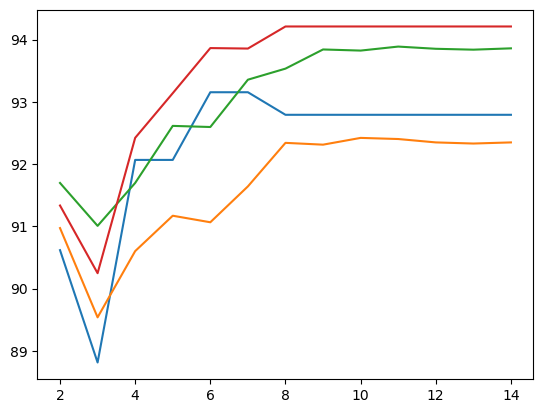

In [18]:
'''
IMPORTANT CONCEPT:

- need to tune tree...find best depth

- cross-validation at each depth is done on 100 different random training sets and the average accuracy at each is recorded

- graph shows best accuracy

- depths changing often with changes in data...

'''
clf_deps = []
#set train and test data
for df in [df_a, df_b, df_c, df_d]:
    df=df.sample(frac=1) 
    train_proportion = 0.8 
    n = len(df)
    t = int(train_proportion * n)

    # separate training and test sets
    y = df['detected']
    X = df.loc[:, ~df.columns.isin(['detected'])]

    #features in training set
    train_x = X.iloc[:t,:].reset_index().iloc[:,1:]
    #features in test set
    test_x = X.iloc[t:,:].reset_index().iloc[:,1:]
    #targets in train set
    train_y = pd.Series(y[:t].reset_index().iloc[:,1:].iloc[:,0])
    #targets in test set
    test_y = pd.Series(y[t:].reset_index().iloc[:,1:].iloc[:,0])

    # define the depths
    depths = np.arange(2,15)
    # create an empty data frame for our results
    results = np.zeros(len(depths))

    for i in range(100):
        for j in range(len(depths)):
            best_depth_tree = DecisionTreeClassifier(max_depth = depths[j]) # creating an instance of a decision tree
            results[j%13] += cross_val_score(best_depth_tree, train_x, 
                                        train_y, scoring="accuracy", # getting the cv accuracy metric for the tree at each depth
                        cv=6).mean()
            
                            

    test = pd.DataFrame({'depths':depths, 'accuracy':results})
    depth = test.loc[test.accuracy.argmax(),'depths']
    print(test.loc[test.accuracy.argmax(),'accuracy'])
    clf_deps = np.append(clf_deps,depth)
    plt.plot(test.depths, test.accuracy)

In [19]:
# define tree IF 1 the same
a_depth = clf_deps[0]
b_depth = clf_deps[1]
c_depth = clf_deps[2]
#raw_depth = 8
d_depth = clf_deps[3]
rs = 8
#clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3)

# final df for display
dfr = pd.DataFrame(index=[a_name, b_name, c_name, d_name], columns=['Avg. Train %', 'Avg. Validation %', 'Avg. Test %',
                                                                    'Best Sc. Train %', 'Best Sc. Validation %', 'Best Sc. Test %'])

In [139]:
df = df_a # number of samples = 347
df=df.sample(frac=1) 
train_proportion = 0.8 
n = len(df)
t = int(train_proportion * n)

# separate training and test sets
y = df['detected']
X = df.loc[:, ~df.columns.isin(['detected'])]

#features in training set
train_x = X.iloc[:t,:].reset_index().iloc[:,1:]
#features in test set
test_x = X.iloc[t:,:].reset_index().iloc[:,1:]
#targets in train set
train_y = pd.Series(y[:t].reset_index().iloc[:,1:].iloc[:,0])
#targets in test set
test_y = pd.Series(y[t:].reset_index().iloc[:,1:].iloc[:,0])

clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 10, random_state= 0, min_samples_leaf=500)
clf.fit(train_x,train_y)
print(clf.score(train_x,train_y))
print(clf.score(test_x,test_y))


0.9205776173285198
0.9285714285714286


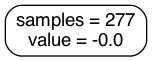

In [140]:
# Get the tree number 42
sub_tree_42 = clf.estimators_[7, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
Image(png)

In [112]:
'''
df_a

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = a_depth, random_state= rs, min_samples_leaf=15)
a_train =[]
a_vals =[]
a_tests=[]
fi_a = np.zeros((len(df_a.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_a, clf, 'bagging')
    a_train = np.append(train_acc, a_train)
    a_vals = np.append(val_acc, a_vals)
    a_tests = np.append(test_acc, a_tests)
    fi_a += model.feature_importances_

    # keep best model
    if test_acc >= np.max(a_tests):
        a_model = model
        a_train_best = train_acc
        a_val_best = val_acc
        a_test_best = test_acc

# keep feature importances
fi_a /= 50

# get average accuracies
a_train_avg = round(np.mean(a_train),1)
a_vals_avg = round(np.mean(a_vals),1)
a_tests_avg = round(np.mean(a_tests),1)

print(f'{a_name} - Results:')
print(f'Best Scenario Training Accuracy: {a_train_best}%')
print(f'Average Training Accuracy: {a_train_avg}%')
print(f'Best Scenario Validation Accuracy: {a_val_best}%')
print(f'Average Validation Accuracy: {a_vals_avg}%')
print(f'Best Scenario Test Accuracy: {a_test_best}%')
print(f'Average Test Accuracy: {a_tests_avg}%')

Add Sand, Silt, Clay - Results:
Best Scenario Training Accuracy: 96.6%
Average Training Accuracy: 96.9%
Best Scenario Validation Accuracy: 95.7%
Average Validation Accuracy: 96.1%
Best Scenario Test Accuracy: 100.0%
Average Test Accuracy: 92.9%


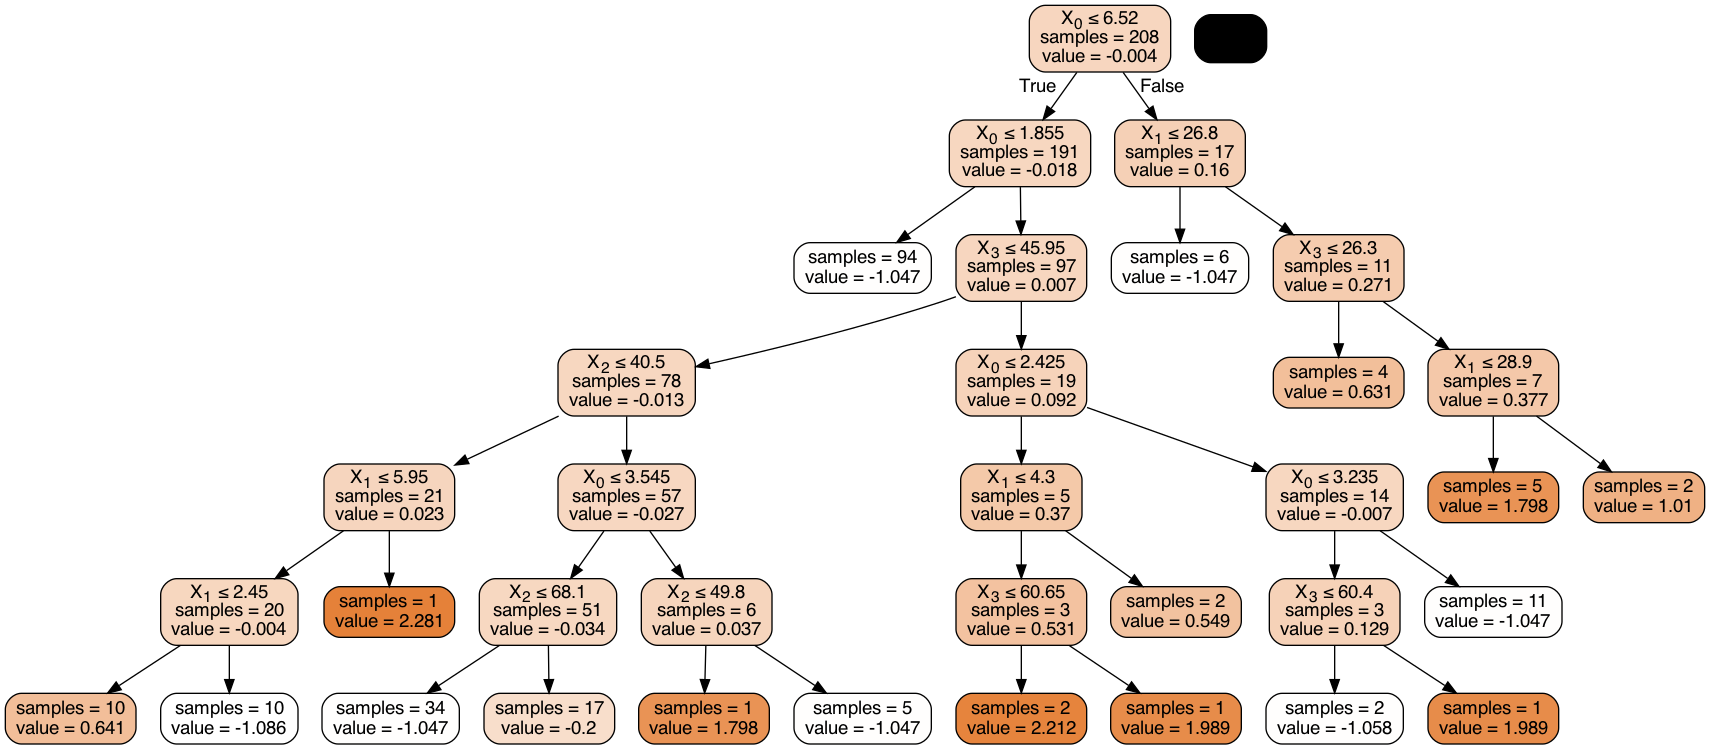

In [46]:
# Get the tree number 42
sub_tree_42 = a_model.estimators_[6, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
Image(png)

In [63]:
clf

GradientBoostingClassifier(max_depth=12.0, min_samples_leaf=350, random_state=8)

In [8]:
'''
df_b

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = b_depth, random_state= rs)
b_train =[]
b_vals =[]
b_tests=[]
fi_b = np.zeros((len(df_b.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_b, clf, 'bagging')
    b_train = np.append(train_acc, b_train)
    b_vals = np.append(val_acc, b_vals)
    b_tests = np.append(test_acc, b_tests)
    fi_b += model.feature_importances_

    # keep best model
    if test_acc >= np.max(b_tests):
        b_model = model
        b_train_best = train_acc
        b_val_best = val_acc
        b_test_best = test_acc

# keep feature importances
fi_b /= 50

# get average accuracies
b_train_avg = round(np.mean(b_train),1)
b_vals_avg = round(np.mean(b_vals),1)
b_tests_avg = round(np.mean(b_tests),1)

print(f'{b_name} - Results:')
print(f'Best Scenario Training Accuracy: {b_train_best}%')
print(f'Average Training Accuracy: {b_train_avg}%')
print(f'Best Scenario Validation Accuracy: {b_val_best}%')
print(f'Average Validation Accuracy: {b_vals_avg}%')
print(f'Best Scenario Test Accuracy: {b_test_best}%')
print(f'Average Test Accuracy: {b_tests_avg}%')


Add Sand, Silt - Results:
Best Scenario Training Accuracy: 96.6%
Average Training Accuracy: 97.2%
Best Scenario Validation Accuracy: 94.2%
Average Validation Accuracy: 95.8%
Best Scenario Test Accuracy: 98.6%
Average Test Accuracy: 93.3%


In [9]:
'''
df_c

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = c_depth, random_state= rs)
c_train =[]
c_vals =[]
c_tests=[]
fi_c = np.zeros((len(df_c.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_c, clf, 'bagging')
    c_train = np.append(train_acc, c_train)
    c_vals = np.append(val_acc, c_vals)
    c_tests = np.append(test_acc, c_tests)
    fi_c += model.feature_importances_

    # keep best model
    if test_acc >= np.max(c_tests):
        c_model = model
        c_train_best = train_acc
        c_val_best = val_acc
        c_test_best = test_acc

# keep feature importances
fi_c /= 50

# get average accuracies
c_train_avg = round(np.mean(c_train),1)
c_vals_avg = round(np.mean(c_vals),1)
c_tests_avg = round(np.mean(c_tests),1)

print(f'{c_name} - Results:')
print(f'Best Scenario Training Accuracy: {c_train_best}%')
print(f'Average Training Accuracy: {c_train_avg}%')
print(f'Best Scenario Validation Accuracy: {c_val_best}%')
print(f'Average Validation Accuracy: {c_vals_avg}%')
print(f'Best Scenario Test Accuracy: {c_test_best}%')
print(f'Average Test Accuracy: {c_tests_avg}%')

Add Sand - Results:
Best Scenario Training Accuracy: 97.1%
Average Training Accuracy: 97.1%
Best Scenario Validation Accuracy: 92.9%
Average Validation Accuracy: 96.0%
Best Scenario Test Accuracy: 100.0%
Average Test Accuracy: 92.8%


In [10]:
'''
Considering just raw values with other features

clf = GradientBoostingClassifier(n_estimators = 100, max_depth = raw_depth, random_state= rs)
raw_train =[]
raw_vals =[]
raw_tests=[]
fi_raw = np.zeros((len(df_raw.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_raw, clf, 'bagging')
    raw_train = np.append(train_acc, raw_train)
    raw_vals = np.append(val_acc, raw_vals)
    raw_tests = np.append(test_acc, raw_tests)
    fi_raw += model.feature_importances_

    # keep best model
    if test_acc >= np.max(raw_tests):
        raw_model = model
        raw_train_best = train_acc
        raw_val_best = val_acc
        raw_test_best = test_acc

# keep feature importances
fi_raw /= 50

# get average accuracies
raw_train_avg = round(np.mean(raw_train),1)
raw_vals_avg = round(np.mean(raw_vals),1)
raw_tests_avg = round(np.mean(raw_tests),1)

print('Raw - Results:')
print(f'Best Scenario Training Accuracy: {raw_train_best}%')
print(f'Average Training Accuracy: {raw_train_avg}%')
print(f'Best Scenario Validation Accuracy: {raw_val_best}%')
print(f'Average Validation Accuracy: {raw_vals_avg}%')
print(f'Best Scenario Test Accuracy: {raw_test_best}%')
print(f'Average Test Accuracy: {raw_tests_avg}%')

'''

"\nConsidering just raw values with other features\n\nclf = GradientBoostingClassifier(n_estimators = 100, max_depth = raw_depth, random_state= rs)\nraw_train =[]\nraw_vals =[]\nraw_tests=[]\nfi_raw = np.zeros((len(df_raw.columns) - 1))\nfor i in range(50):\n    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_raw, clf, 'bagging')\n    raw_train = np.append(train_acc, raw_train)\n    raw_vals = np.append(val_acc, raw_vals)\n    raw_tests = np.append(test_acc, raw_tests)\n    fi_raw += model.feature_importances_\n\n    # keep best model\n    if test_acc >= np.max(raw_tests):\n        raw_model = model\n        raw_train_best = train_acc\n        raw_val_best = val_acc\n        raw_test_best = test_acc\n\n# keep feature importances\nfi_raw /= 50\n\n# get average accuracies\nraw_train_avg = round(np.mean(raw_train),1)\nraw_vals_avg = round(np.mean(raw_vals),1)\nraw_tests_avg = round(np.mean(raw_tests),1)\n\nprint('Raw - Results:')\nprint(f'Best Scenario Training Accuracy: {raw_tr

In [11]:
'''
df_d

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = d_depth, random_state= rs)
d_train =[]
d_vals =[]
d_tests=[]
fi_d = np.zeros((len(df_d.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_d, clf, 'bagging')
    d_train = np.append(train_acc, d_train)
    d_vals = np.append(val_acc, d_vals)
    d_tests = np.append(test_acc, d_tests)
    fi_d += model.feature_importances_

    # keep best model
    if test_acc >= np.max(d_tests):
        d_model = model
        d_train_best = train_acc
        d_val_best = val_acc
        d_test_best = test_acc

# keep feature importances
fi_d /= 50

# get average accuracies
d_train_avg = round(np.mean(d_train),1)
d_vals_avg = round(np.mean(d_vals),1)
d_tests_avg = round(np.mean(d_tests),1)

print(f'{d_name} - Results:')
print(f'Best Scenario Training Accuracy: {d_train_best}%')
print(f'Average Training Accuracy: {d_train_avg}%')
print(f'Best Scenario Validation Accuracy: {d_val_best}%')
print(f'Average Validation Accuracy: {d_vals_avg}%')
print(f'Best Scenario Test Accuracy: {d_test_best}%')
print(f'Average Test Accuracy: {d_tests_avg}%')


US - Results:
Best Scenario Training Accuracy: 97.1%
Average Training Accuracy: 97.0%
Best Scenario Validation Accuracy: 94.2%
Average Validation Accuracy: 95.9%
Best Scenario Test Accuracy: 98.6%
Average Test Accuracy: 92.4%


In [12]:
print(len(df_a['Sand %'].unique()))
print(len(df_a['tgus'].unique()))

14
64


In [36]:
# fill results table
dfr.loc[a_name,:] = [a_train_avg, a_vals_avg, a_tests_avg, a_train_best, a_val_best, a_test_best]
dfr.loc[b_name,:] = [b_train_avg, b_vals_avg, b_tests_avg, b_train_best, b_val_best, b_test_best]
dfr.loc[c_name,:] = [c_train_avg, c_vals_avg, c_tests_avg, c_train_best, c_val_best, c_test_best]
dfr.loc[d_name,:] = [d_train_avg, d_vals_avg, d_tests_avg, d_train_best, d_val_best, d_test_best]


print(tabulate(dfr, headers='keys', tablefmt = 'fancy_grid', numalign = 'center'))

NameError: name 'b_train_avg' is not defined

NameError: name 'fi_d' is not defined

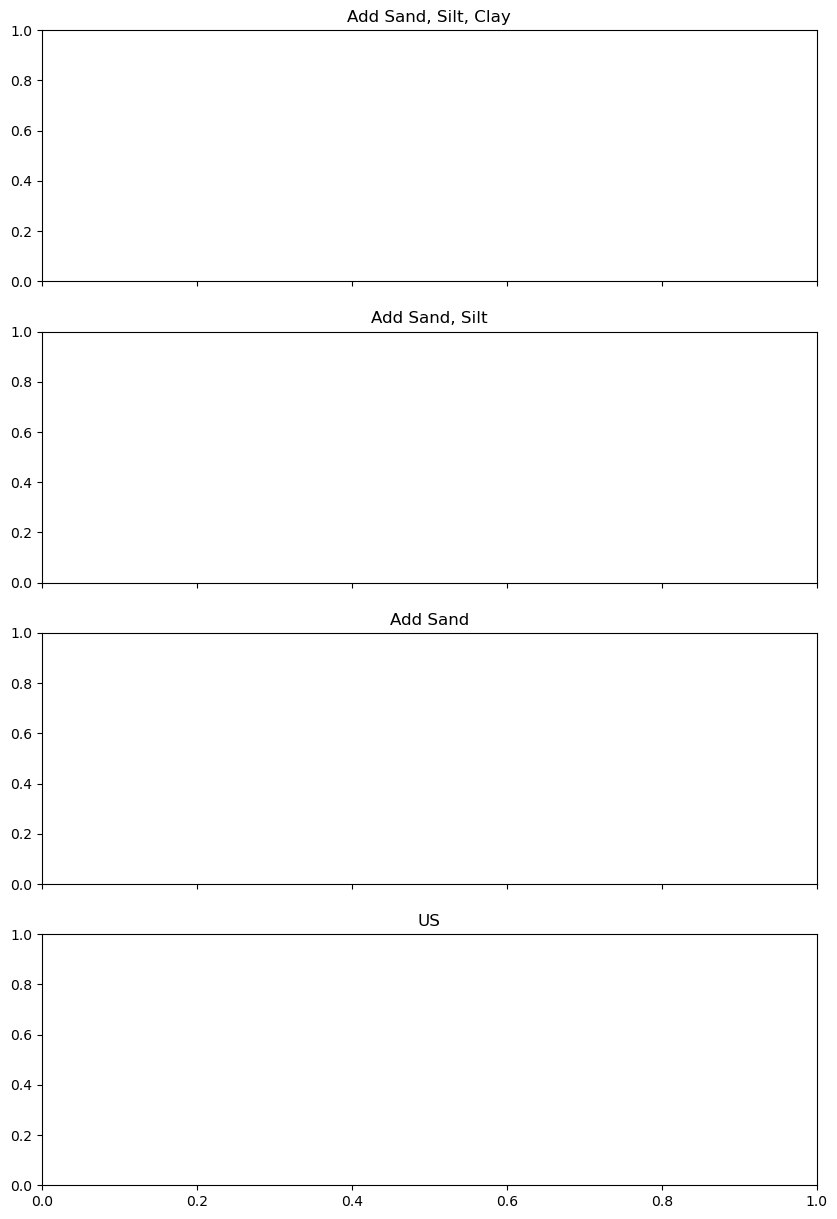

In [37]:
'''setup figures for plotting'''
fig, ([axA, axB, axC, axD]) = plt.subplots(nrows=4, ncols=1, figsize =(10,15), sharex = True)

axB.set_title(b_name,fontsize=12)
axC.set_title(c_name,fontsize=12)
axA.set_title(a_name,fontsize=12)
axD.set_title(d_name,fontsize=12)


y_dict = {'detlimit': 'Detection Limit', 'gus': 'GUS', 'koc [m^3/Mg]':'Partition Coefficient', 'tgus':'TGUS', 'medium':'Medium Aq. Vuln.', 'soil_halflife': 'Soil Half-life', 
        'high':'High Aq. Vuln.', 'Poorly drained':'Poorly Drained', 'Well drained':'Well Drained', 'Moderately well drained':'Moderately Well Drained', 
        'Somewhat poorly drained':'Somewhat Poorly Drained', 'low':'Low Aq. Vuln.', 'Very poorly drained':'Very Poorly Drained', 'Somewhat excessively drained':'Somewhat Excessively Drained',
        'offset':'Offset', 'aquifer_vulnerability': 'Aq. Vuln.', 'drainage_class':'Drainage Class', 'Sand %': 'Sand %', 'Silt %': 'Silt %', 'Clay %': 'Clay %'}

pal = sns.color_palette('crest_r')

fi_d = pd.Series(np.round(fi_d,2), index = df_d.drop('detected', axis = 1).columns)
fi_d = fi_d.sort_values(ascending=False)
arr=np.array(fi_d.index)
axD=sns.barplot(ax=axD,x=np.array(fi_d.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
for i in axD.containers:
    axD.bar_label(i,)

fi_c = pd.Series(np.round(fi_c,2), index = df_c.drop('detected', axis = 1).columns)
fi_c = fi_c.sort_values(ascending=False)
arr=np.array(fi_c.index)
axC=sns.barplot(ax=axC,x=np.array(fi_c.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
for i in axC.containers:
    axC.bar_label(i,)

fi_b = pd.Series(np.round(fi_b,2), index = df_b.drop('detected', axis = 1).columns)
fi_b = fi_b.sort_values(ascending=False)
arr=np.array(fi_b.index)
axB=sns.barplot(ax=axB,x=np.array(fi_b.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr),palette = pal)
for i in axB.containers:
    axB.bar_label(i,)

fi_a = pd.Series(np.round(fi_a,2), index = df_a.drop('detected', axis = 1).columns)
fi_a = fi_a.sort_values(ascending=False)
arr=np.array(fi_a.index)
axA=sns.barplot(ax=axA,x=np.array(fi_a.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
axD.set_xlabel('Relative Feature Importance')
for i in axA.containers:
    axA.bar_label(i,)



In [15]:
'''
Equal variance t-tests to compare result means
'''
cols = [a_name, b_name, c_name, d_name]
train_scores = pd.DataFrame({a_name: a_train, b_name: b_train, c_name: c_train, d_name: d_train})
val_scores = pd.DataFrame({a_name: a_vals, b_name: b_vals, c_name: c_vals, d_name: d_vals})
test_scores = pd.DataFrame({a_name: a_tests, b_name: b_tests, c_name: c_tests, d_name: d_tests})

comp_train = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )
comp_val = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )
comp_test = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )

for i in cols:
    for j in cols:
        stat_train,p_train = sts.ttest_ind(train_scores.loc[:,i], train_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_train.loc[i,j] = [round(p_train,100)]

        stat_val,p_val = sts.ttest_ind(val_scores.loc[:,i], val_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_val.loc[i,j] = [round(p_val,100)]

        stat_test,p_test = sts.ttest_ind(test_scores.loc[:,i], test_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_test.loc[i,j] = [round(p_test,100)]

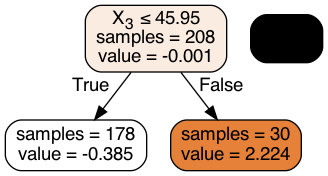

In [69]:
# Get the tree number 42
sub_tree_42 = a_model.estimators_[3, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
Image(png)

In [59]:
a_model

GradientBoostingClassifier(max_depth=12.0, min_samples_leaf=300, random_state=8)